# Stage 11 Homework — Evaluation & Risk Communication
In the lecture, we learned **parametric vs bootstrap CIs**, **scenario sensitivity**, and **subgroup checks**.
Now, you will adapt those methods to your dataset and produce assumption-aware results.

In [17]:
# Stage 11: Evaluation & Risk Communication

# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(111)

# Import helper functions
import sys
sys.path.append('../src')
from evaluation import *

# Set plotting style
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")
print("Setup complete!")

Setup complete!


## Load Data (provided or synthetic fallback)

In [18]:
# Load data
data_dir = Path('../data')
data_dir.mkdir(exist_ok=True)

csv_path = data_dir / 'data_stage11_eval_risk.csv'

if csv_path.exists():
    try:
        df = pd.read_csv(csv_path, parse_dates=['date'])
        print("Loaded existing data")
    except ValueError as e:
        print(f"Error reading CSV: {e}\nRegenerating synthetic data...")
        regenerate = True
    else:
        regenerate = False
else:
    print("No existing data found. Generating synthetic data...")
    regenerate = True

if regenerate:
    n = 180
    dates = pd.date_range('2022-06-01', periods=n, freq='D')
    seg = np.random.choice(['A','B','C'], size=n, p=[0.5,0.3,0.2])
    x = np.linspace(0, 9, n) + np.random.normal(0, 0.7, n)
    y = 2.1 * x + 0.8 + np.random.standard_t(df=3, size=n) * 1.1
    x[np.random.choice(np.arange(n), size=round(0.05*n), replace=False)] = np.nan
    df = pd.DataFrame({'date': dates, 'segment': seg, 'x_feature': x, 'y_target': y})
    df.to_csv(csv_path, index=False)
    print("Synthetic data generated and saved")

print("\nData Overview:")
print(f"Shape: {df.shape}")
print(f"Missing values in x_feature: {df['x_feature'].isna().sum()}")
print(f"Segments: {df['segment'].value_counts().to_dict()}")
df.head()

Loaded existing data

Data Overview:
Shape: (180, 4)
Missing values in x_feature: 9
Segments: {'A': 94, 'C': 45, 'B': 41}


,date,segment,x_feature,y_target
0,2022-06-01,B,0.547868,2.107524
1,2022-06-02,A,0.974480,2.209111
2,2022-06-03,A,-0.012991,0.867315
3,2022-06-04,B,-1.012503,-1.741932
4,2022-06-05,A,0.642399,1.615007


## Helper Functions (complete or modify as needed)

In [19]:
def mean_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmean(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

def median_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmedian(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

class SimpleLinReg:
    def fit(self, X, y):
        X1 = np.c_[np.ones(len(X)), X.ravel()]
        beta = np.linalg.pinv(X1) @ y
        self.intercept_, self.coef_ = float(beta[0]), np.array([float(beta[1])])
        return self
    def predict(self, X):
        return self.intercept_ + self.coef_[0] * X.ravel()

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

# def bootstrap_metric(y_true, y_pred, fn, n_boot=500, seed=111, alpha=0.05):
#     rng = np.random.default_rng(seed)
#     idx = np.arange(len(y_true))
#     stats = []
#     for _ in range(n_boot):
#         b = rng.choice(idx, size=len(idx), replace=True)
#         stats.append(fn(y_true[b], y_pred[b]))
#     lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
#     return {'mean': float(np.mean(stats)), 'lo': float(lo), 'hi': float(hi)}

def fit_fn(X, y):
    return SimpleLinReg().fit(X, y)
def pred_fn(model, X):
    return model.predict(X)

## Baseline Fit & Residuals (Required)

### Baseline Model Fit

=== Baseline Model Fit ===
Baseline MAE: 1.2783
Baseline RMSE: 2.0819
Baseline R²: 0.8778
Model: y = 0.712 + 2.130 * x


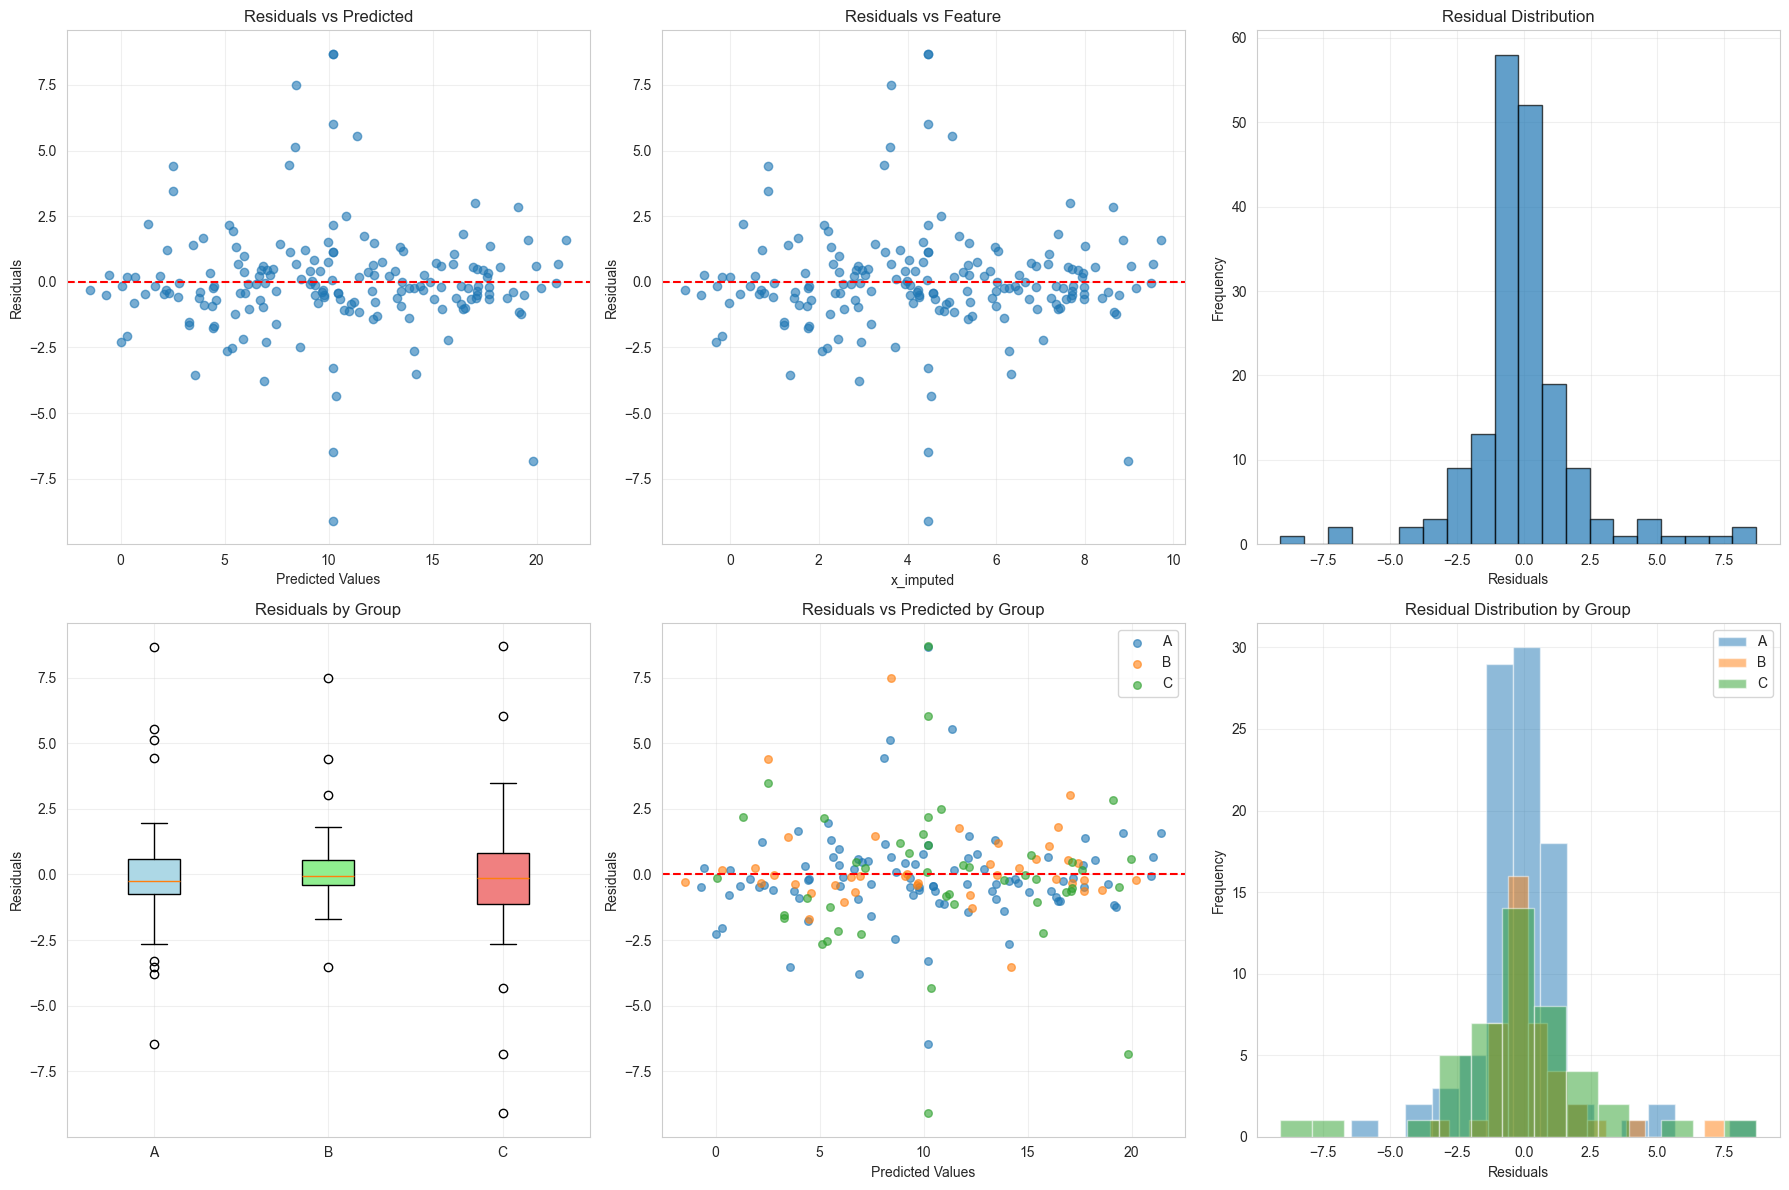

In [20]:
# Baseline Model Fit
print("=== Baseline Model Fit ===")

X_raw = df['x_feature'].values
y = df['y_target'].values
X_base = mean_impute(X_raw)
model = fit_fn(X_base.reshape(-1,1), y)
y_hat = model.predict(X_base.reshape(-1,1))
# Store results
df['x_imputed'] = X_base
df['y_hat'] = y_hat
df['residuals'] = y - y_hat

# Compute metrics
base_mae = mae(y, y_hat)
base_rmse = rmse(y, y_hat)
base_r2 = r2_score(y, y_hat)

print(f"Baseline MAE: {base_mae:.4f}")
print(f"Baseline RMSE: {base_rmse:.4f}")
print(f"Baseline R²: {base_r2:.4f}")
print(f"Model: y = {model.intercept_:.3f} + {model.coef_[0]:.3f} * x")

# Residual diagnostics
create_diagnostic_plots(df, 'segment', 'y_target', 'y_hat', 'x_imputed')

### Bootstrap Analysis

=== Bootstrap Analysis ===
Bootstrapping MAE...
MAE Bootstrap Results:
  Mean: 1.2714
  95% CI: [1.0551, 1.5310]

Bootstrapping RMSE...
RMSE Bootstrap Results:
  Mean: 2.0544
  95% CI: [1.6281, 2.4918]

Bootstrapping coefficients...
Intercept Bootstrap Results:
  Mean: 0.7195
  95% CI: [0.2408, 1.2291]
Slope Bootstrap Results:
  Mean: 2.1282
  95% CI: [2.0388, 2.2126]


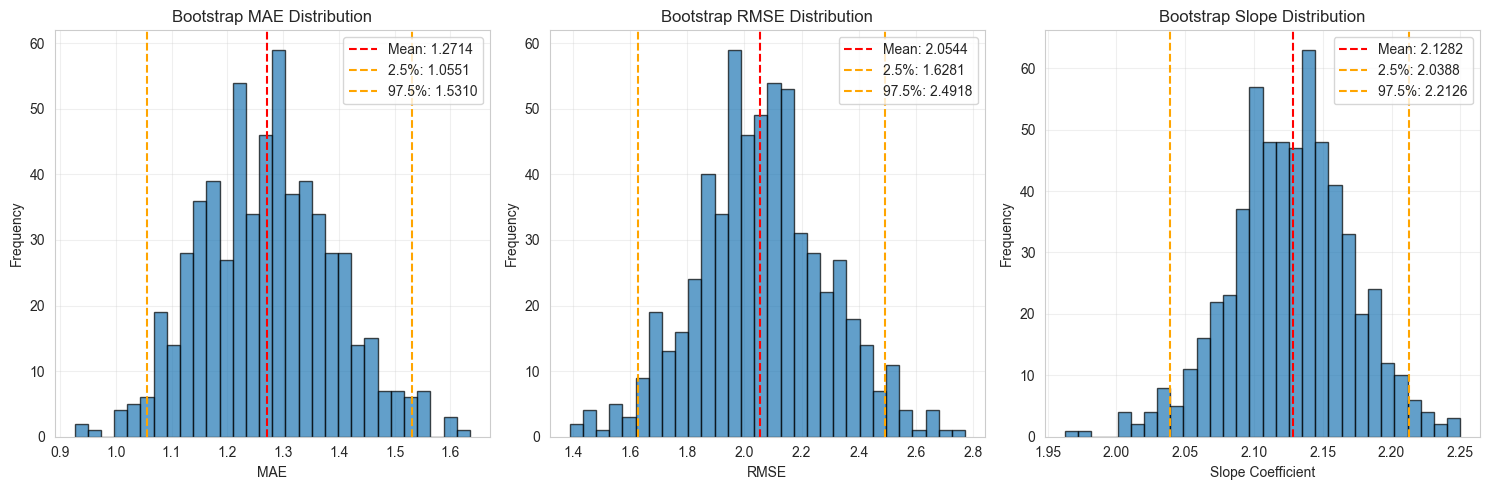

In [21]:
# Bootstrap Analysis
print("=== Bootstrap Analysis ===")

# Bootstrap MAE
print("Bootstrapping MAE...")
bm_mae = bootstrap_metric(y, df['y_hat'].values, mae, n_boot=600)
print(f"MAE Bootstrap Results:")
print(f"  Mean: {bm_mae['mean']:.4f}")
print(f"  95% CI: [{bm_mae['lo']:.4f}, {bm_mae['hi']:.4f}]")

# Bootstrap RMSE
print("\nBootstrapping RMSE...")
bm_rmse = bootstrap_metric(y, df['y_hat'].values, rmse, n_boot=600)
print(f"RMSE Bootstrap Results:")
print(f"  Mean: {bm_rmse['mean']:.4f}")
print(f"  95% CI: [{bm_rmse['lo']:.4f}, {bm_rmse['hi']:.4f}]")

# Bootstrap coefficients
print("\nBootstrapping coefficients...")
bm_coef = bootstrap_coefficients(X_base, y, n_boot=600)
print(f"Intercept Bootstrap Results:")
print(f"  Mean: {bm_coef['intercept']['mean']:.4f}")
print(f"  95% CI: [{bm_coef['intercept']['lo']:.4f}, {bm_coef['intercept']['hi']:.4f}]")
print(f"Slope Bootstrap Results:")
print(f"  Mean: {bm_coef['slope']['mean']:.4f}")
print(f"  95% CI: [{bm_coef['slope']['lo']:.4f}, {bm_coef['slope']['hi']:.4f}]")

# Visualize bootstrap distributions
plt.figure(figsize=(15, 5))

# Bootstrap MAE distribution
plt.subplot(1, 3, 1)
mae_boots = []
rng = np.random.default_rng(111)
idx = np.arange(len(y))
for _ in range(600):
    b = rng.choice(idx, size=len(idx), replace=True)
    mae_boots.append(mae(y[b], df['y_hat'].values[b]))

plt.hist(mae_boots, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(bm_mae['mean'], color='red', linestyle='--', label=f"Mean: {bm_mae['mean']:.4f}")
plt.axvline(bm_mae['lo'], color='orange', linestyle='--', label=f"2.5%: {bm_mae['lo']:.4f}")
plt.axvline(bm_mae['hi'], color='orange', linestyle='--', label=f"97.5%: {bm_mae['hi']:.4f}")
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.title('Bootstrap MAE Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Bootstrap RMSE distribution
plt.subplot(1, 3, 2)
rmse_boots = []
for _ in range(600):
    b = rng.choice(idx, size=len(idx), replace=True)
    rmse_boots.append(rmse(y[b], df['y_hat'].values[b]))

plt.hist(rmse_boots, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(bm_rmse['mean'], color='red', linestyle='--', label=f"Mean: {bm_rmse['mean']:.4f}")
plt.axvline(bm_rmse['lo'], color='orange', linestyle='--', label=f"2.5%: {bm_rmse['lo']:.4f}")
plt.axvline(bm_rmse['hi'], color='orange', linestyle='--', label=f"97.5%: {bm_rmse['hi']:.4f}")
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.title('Bootstrap RMSE Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Bootstrap slope distribution
plt.subplot(1, 3, 3)
slope_boots = []
for _ in range(600):
    b = rng.choice(idx, size=len(idx), replace=True)
    m = fit_fn(X_base[b].reshape(-1,1), y[b])
    slope_boots.append(m.coef_[0])

plt.hist(slope_boots, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(bm_coef['slope']['mean'], color='red', linestyle='--', 
            label=f"Mean: {bm_coef['slope']['mean']:.4f}")
plt.axvline(bm_coef['slope']['lo'], color='orange', linestyle='--', 
            label=f"2.5%: {bm_coef['slope']['lo']:.4f}")
plt.axvline(bm_coef['slope']['hi'], color='orange', linestyle='--', 
            label=f"97.5%: {bm_coef['slope']['hi']:.4f}")
plt.xlabel('Slope Coefficient')
plt.ylabel('Frequency')
plt.title('Bootstrap Slope Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Parametric vs Bootstrap CI (Required)

In [22]:
# Parametric vs Bootstrap Confidence Intervals
print("=== Parametric vs Bootstrap Confidence Intervals ===")

=== Parametric vs Bootstrap Confidence Intervals ===


Computing bootstrap confidence intervals...


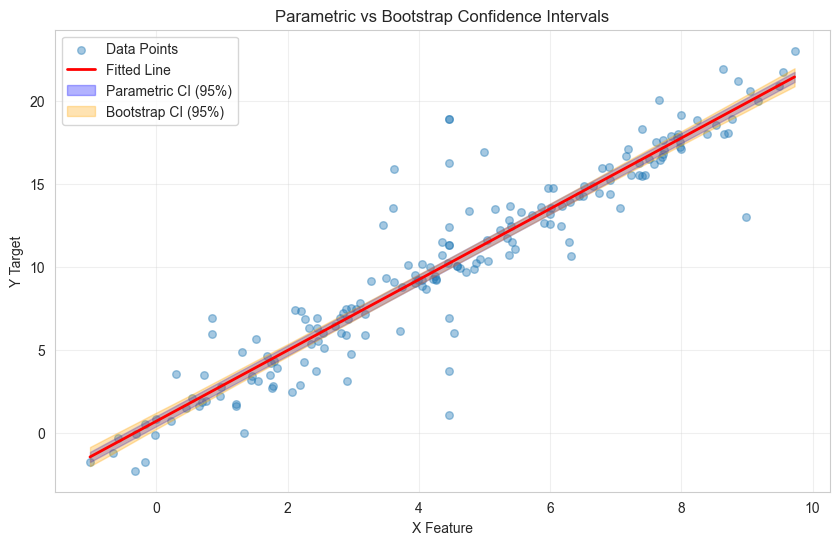

In [23]:
resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)
n = len(y)
se_mean = sigma_hat/np.sqrt(n)
x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)
pred_line = model.predict(x_grid)
gauss_lo = pred_line - 1.96*se_mean
gauss_hi = pred_line + 1.96*se_mean

def bootstrap_predictions(X, y, x_grid, n_boot=500, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1,1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    return P.mean(axis=0), np.percentile(P, 2.5, axis=0), np.percentile(P, 97.5, axis=0)

# Bootstrap CI (no distributional assumptions)
print("Computing bootstrap confidence intervals...")
m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, x_grid, n_boot=600)

# Plot comparison
plt.figure(figsize=(10, 6))
plt.scatter(X_base, y, alpha=0.4, s=30, label='Data Points')
plt.plot(x_grid, pred_line, 'r-', linewidth=2, label='Fitted Line')

# Parametric CI
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, alpha=0.3, 
                 color='blue', label='Parametric CI (95%)')

# Bootstrap CI
plt.fill_between(x_grid.ravel(), lo_boot, hi_boot, alpha=0.3, 
                 color='orange', label='Bootstrap CI (95%)')

plt.xlabel('X Feature')
plt.ylabel('Y Target')
plt.title('Parametric vs Bootstrap Confidence Intervals')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Compare CI widths

In [24]:
print(f"Parametric CI width (avg): {np.mean(gauss_hi - gauss_lo):.4f}")
print(f"Bootstrap CI width (avg): {np.mean(hi_boot - lo_boot):.4f}")
print(f"Ratio (Bootstrap/Parametric): {np.mean(hi_boot - lo_boot)/np.mean(gauss_hi - gauss_lo):.3f}")

print("\nKey Insight: Bootstrap CIs are typically wider than parametric CIs,")
print("indicating that the Gaussian assumption may be overly optimistic.")

Parametric CI width (avg): 0.6100
Bootstrap CI width (avg): 0.7909
Ratio (Bootstrap/Parametric): 1.297

Key Insight: Bootstrap CIs are typically wider than parametric CIs,
indicating that the Gaussian assumption may be overly optimistic.


## Scenario Sensitivity (Required): Choose ≥2 Scenarios
Examples: mean vs median impute; drop; alternate feature transform

Scenario Sensitivity Results:
        scenario     mae    rmse      r2   slope  intercept  n_obs
0    mean_impute  1.2783  2.0819  0.8778  2.1302     0.7115    180
1  median_impute  1.2840  2.0880  0.8771  2.1293     0.7271    180
2   drop_missing  1.0646  1.6219  0.9257  2.1302     0.6592    171
3      zero_fill  1.7475  2.9868  0.7485  1.8444     2.3959    180
4   forward_fill  1.1045  1.6654  0.9218  2.1012     0.7475    180


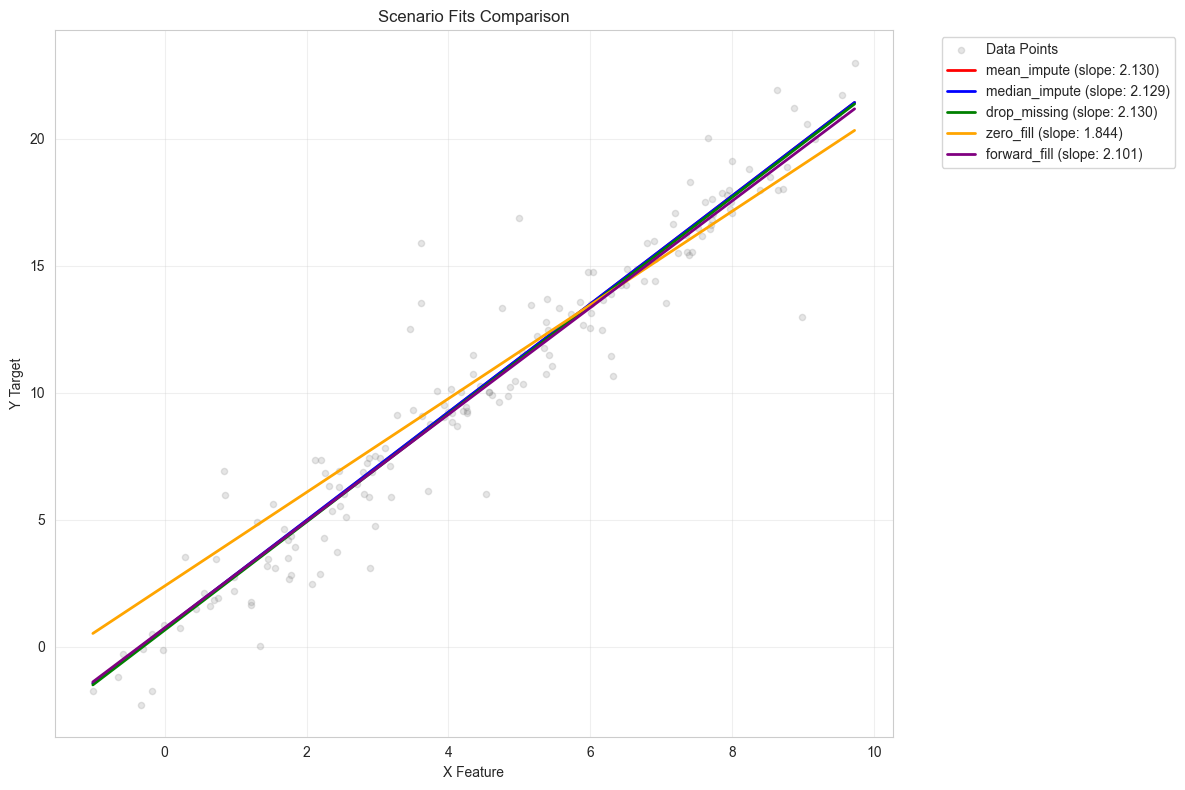

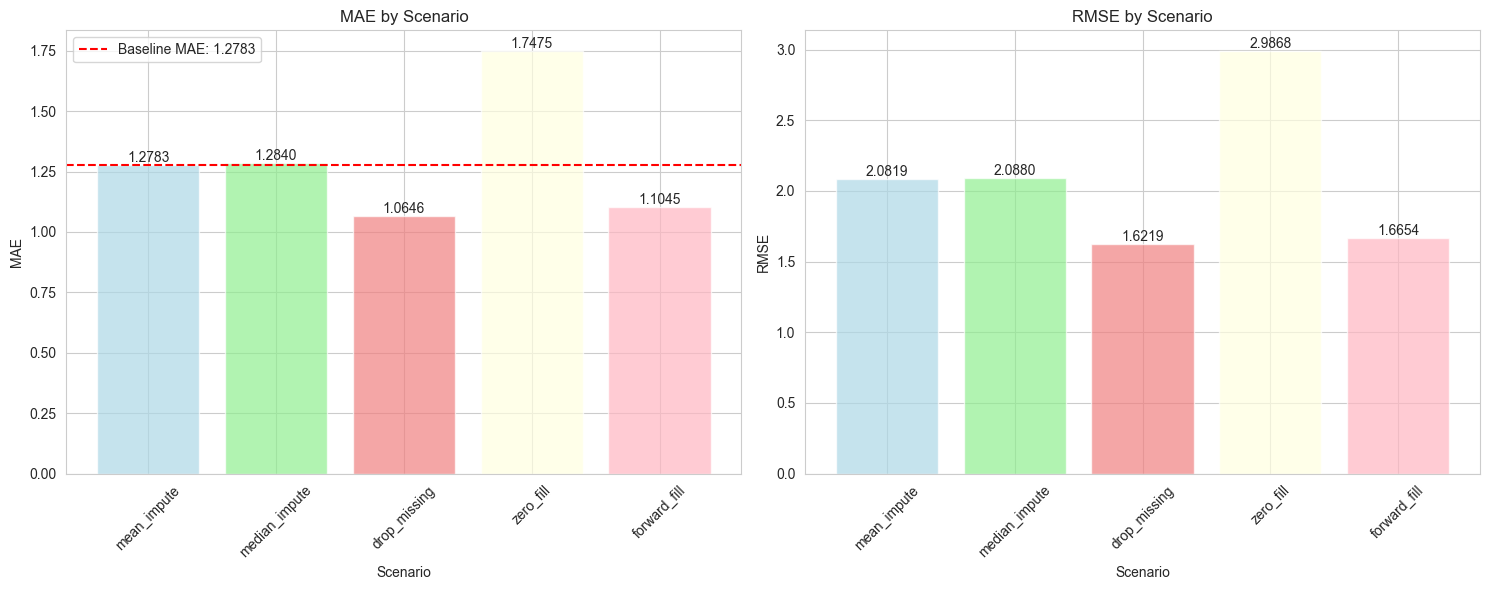

In [25]:
scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': drop_missing,
    'zero_fill': zero_fill,
    'forward_fill': forward_fill
}

# Run sensitivity analysis
results = scenario_sensitivity_analysis(X_raw, y, scenarios)
print("Scenario Sensitivity Results:")
print(results.round(4))

# Create scenario comparison plot
create_scenario_comparison_plot(X_raw, y, scenarios)

# Create metric comparison plot
create_metric_comparison_plot(results, baseline_metric=base_mae)

### Summary of key findings

In [26]:
print("\n=== Scenario Sensitivity Summary ===")
best_scenario = results.loc[results['mae'].idxmin()]
worst_scenario = results.loc[results['mae'].idxmax()]
print(f"Most Robust: {best_scenario['scenario']} - MAE: {best_scenario['mae']:.4f}")
print(f"Least Robust: {worst_scenario['scenario']} - MAE: {worst_scenario['mae']:.4f}")
print(f"MAE Range: {results['mae'].max() - results['mae'].min():.4f}")
print(f"Slope Range: {results['slope'].max() - results['slope'].min():.4f}")


=== Scenario Sensitivity Summary ===
Most Robust: drop_missing - MAE: 1.0646
Least Robust: zero_fill - MAE: 1.7475
MAE Range: 0.6829
Slope Range: 0.2858


## Subgroup Diagnostic (Required)

Residual Statistics by Segment:
         count    mean     std  median     min     max
segment                                               
A           94 -0.0663  1.8275 -0.2356 -6.4716  8.6669
B           41  0.2950  1.7075 -0.0774 -3.5246  7.4824
C           45 -0.1302  2.8132 -0.1404 -9.1016  8.6925

Statistical Tests for Group Differences:
  group1 group2  t_stat  p_value  significant
0      B      A  1.0770   0.2834        False
1      B      C  0.8372   0.4048        False
2      A      C  0.1608   0.8725        False

✅ No significant differences detected between segments


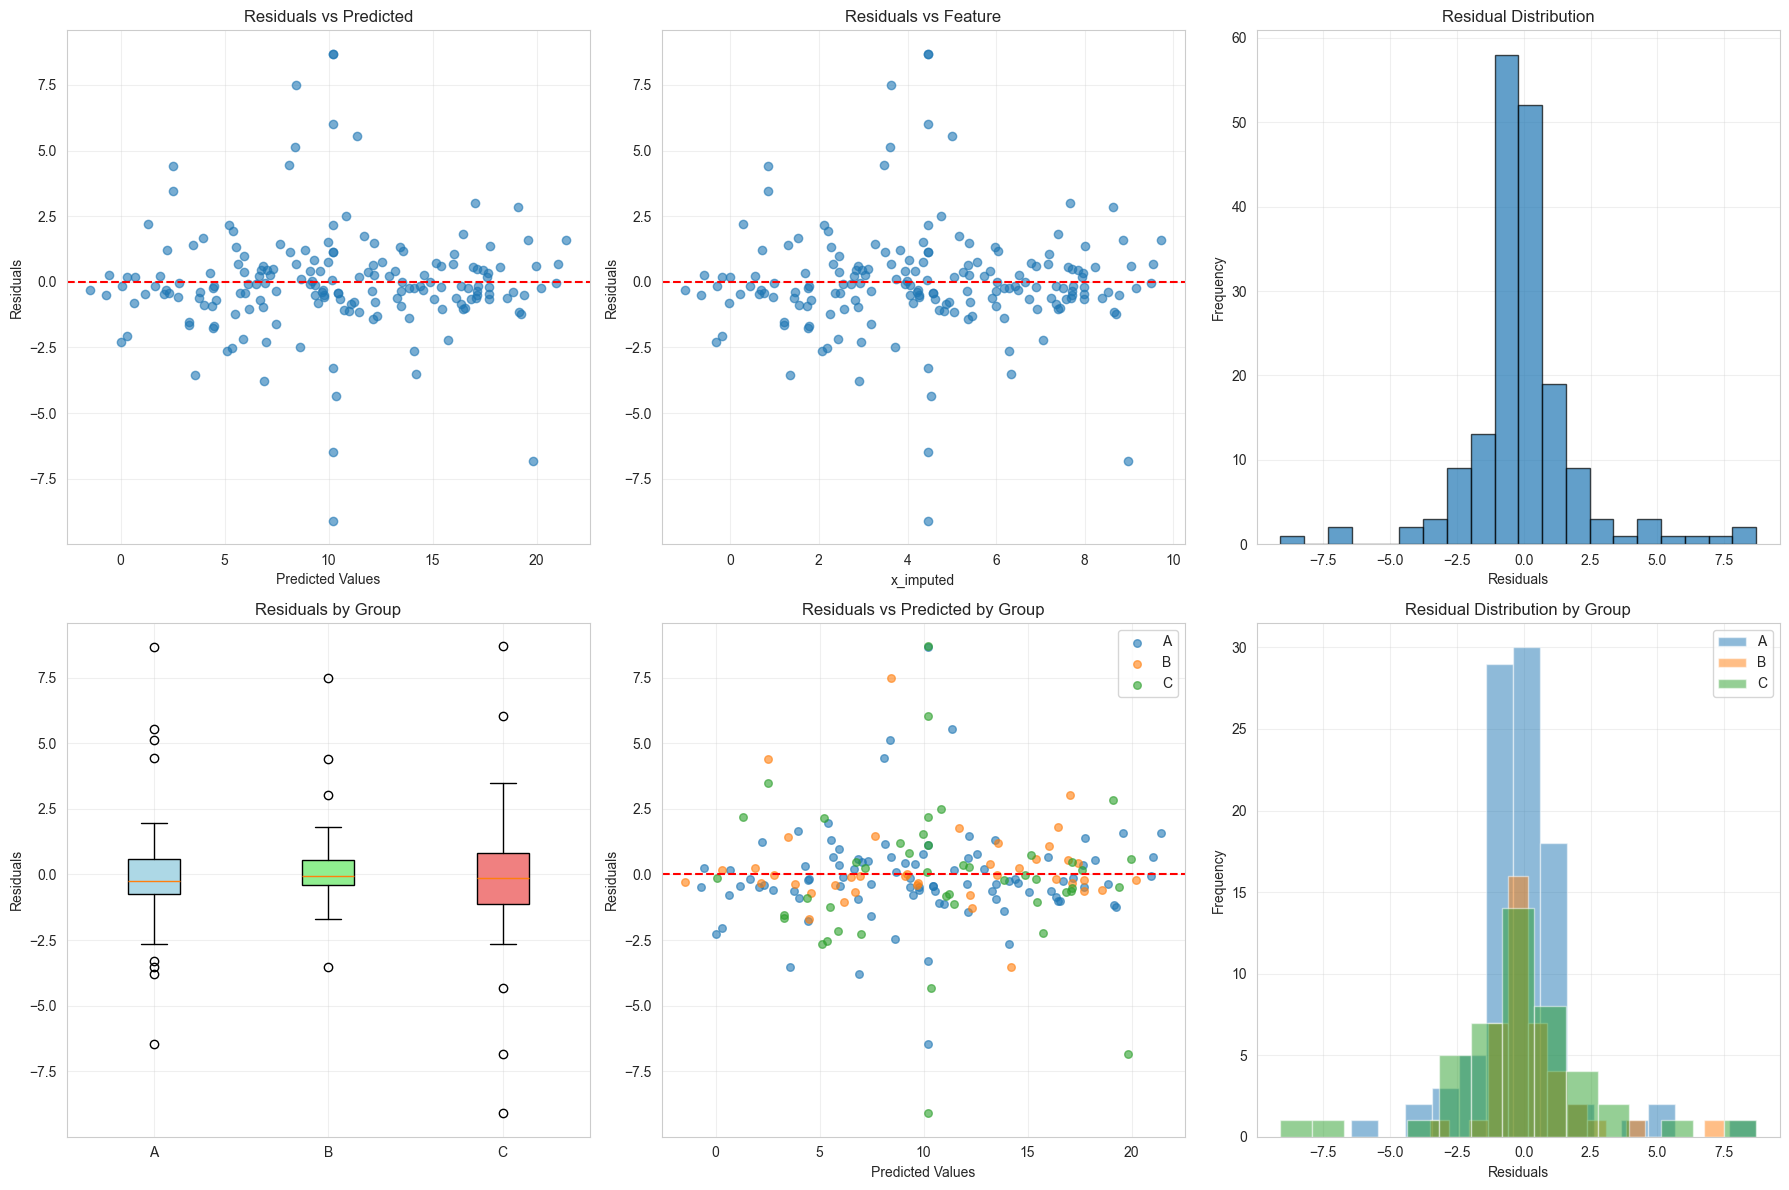


=== Subgroup Performance Analysis ===
Segment B:
  Sample size: 41
  MAE: 0.9894
  RMSE: 1.7122
  R²: 0.9199

Segment A:
  Sample size: 94
  MAE: 1.1418
  RMSE: 1.8190
  R²: 0.9070

Segment C:
  Sample size: 45
  MAE: 1.8267
  RMSE: 2.7848
  R²: 0.7689



In [27]:
# Perform subgroup analysis
group_stats, group_tests = subgroup_diagnostics(df, 'segment', 'y_target', 'y_hat')

print("Residual Statistics by Segment:")
print(group_stats)

print("\nStatistical Tests for Group Differences:")
if not group_tests.empty:
    print(group_tests.round(4))
    
    # Check for significant differences
    significant_pairs = group_tests[group_tests['significant'] == True]
    if not significant_pairs.empty:
        print("\n⚠️  SIGNIFICANT DIFFERENCES DETECTED:")
        for _, row in significant_pairs.iterrows():
            print(f"  {row['group1']} vs {row['group2']}: p={row['p_value']:.4f}")
    else:
        print("\n✅ No significant differences detected between segments")
else:
    print("No group comparisons possible")

# Visualize subgroup diagnostics
create_diagnostic_plots(df, 'segment', 'y_target', 'y_hat', 'x_imputed')

# Additional subgroup analysis
print("\n=== Subgroup Performance Analysis ===")
for segment in df['segment'].unique():
    seg_data = df[df['segment'] == segment]
    seg_mae = mae(seg_data['y_target'], seg_data['y_hat'])
    seg_rmse = rmse(seg_data['y_target'], seg_data['y_hat'])
    seg_r2 = r2_score(seg_data['y_target'], seg_data['y_hat'])
    
    print(f"Segment {segment}:")
    print(f"  Sample size: {len(seg_data)}")
    print(f"  MAE: {seg_mae:.4f}")
    print(f"  RMSE: {seg_rmse:.4f}")
    print(f"  R²: {seg_r2:.4f}")
    print()

## Bootstrap a Metric (Required)

=== Bootstrap Analysis for Key Metrics ===
1. Bootstrapping MAE...
MAE Bootstrap Results:
  Mean: 1.2714
  95% CI: [1.0551, 1.5310]
  Standard Error: 0.1187

2. Bootstrapping RMSE...
RMSE Bootstrap Results:
  Mean: 2.0544
  95% CI: [1.6281, 2.4918]
  Standard Error: 0.2224

3. Bootstrapping R² Score...
R² Bootstrap Results:
  Mean: 0.8784
  95% CI: [0.8237, 0.9264]
  Standard Error: 0.0263

4. Bootstrapping Regression Coefficients...
Intercept Bootstrap Results:
  Mean: 0.7195
  95% CI: [0.2408, 1.2291]
  Standard Error: 0.2582
Slope Bootstrap Results:
  Mean: 2.1282
  95% CI: [2.0388, 2.2126]
  Standard Error: 0.0451

5. Visualizing Bootstrap Distributions...


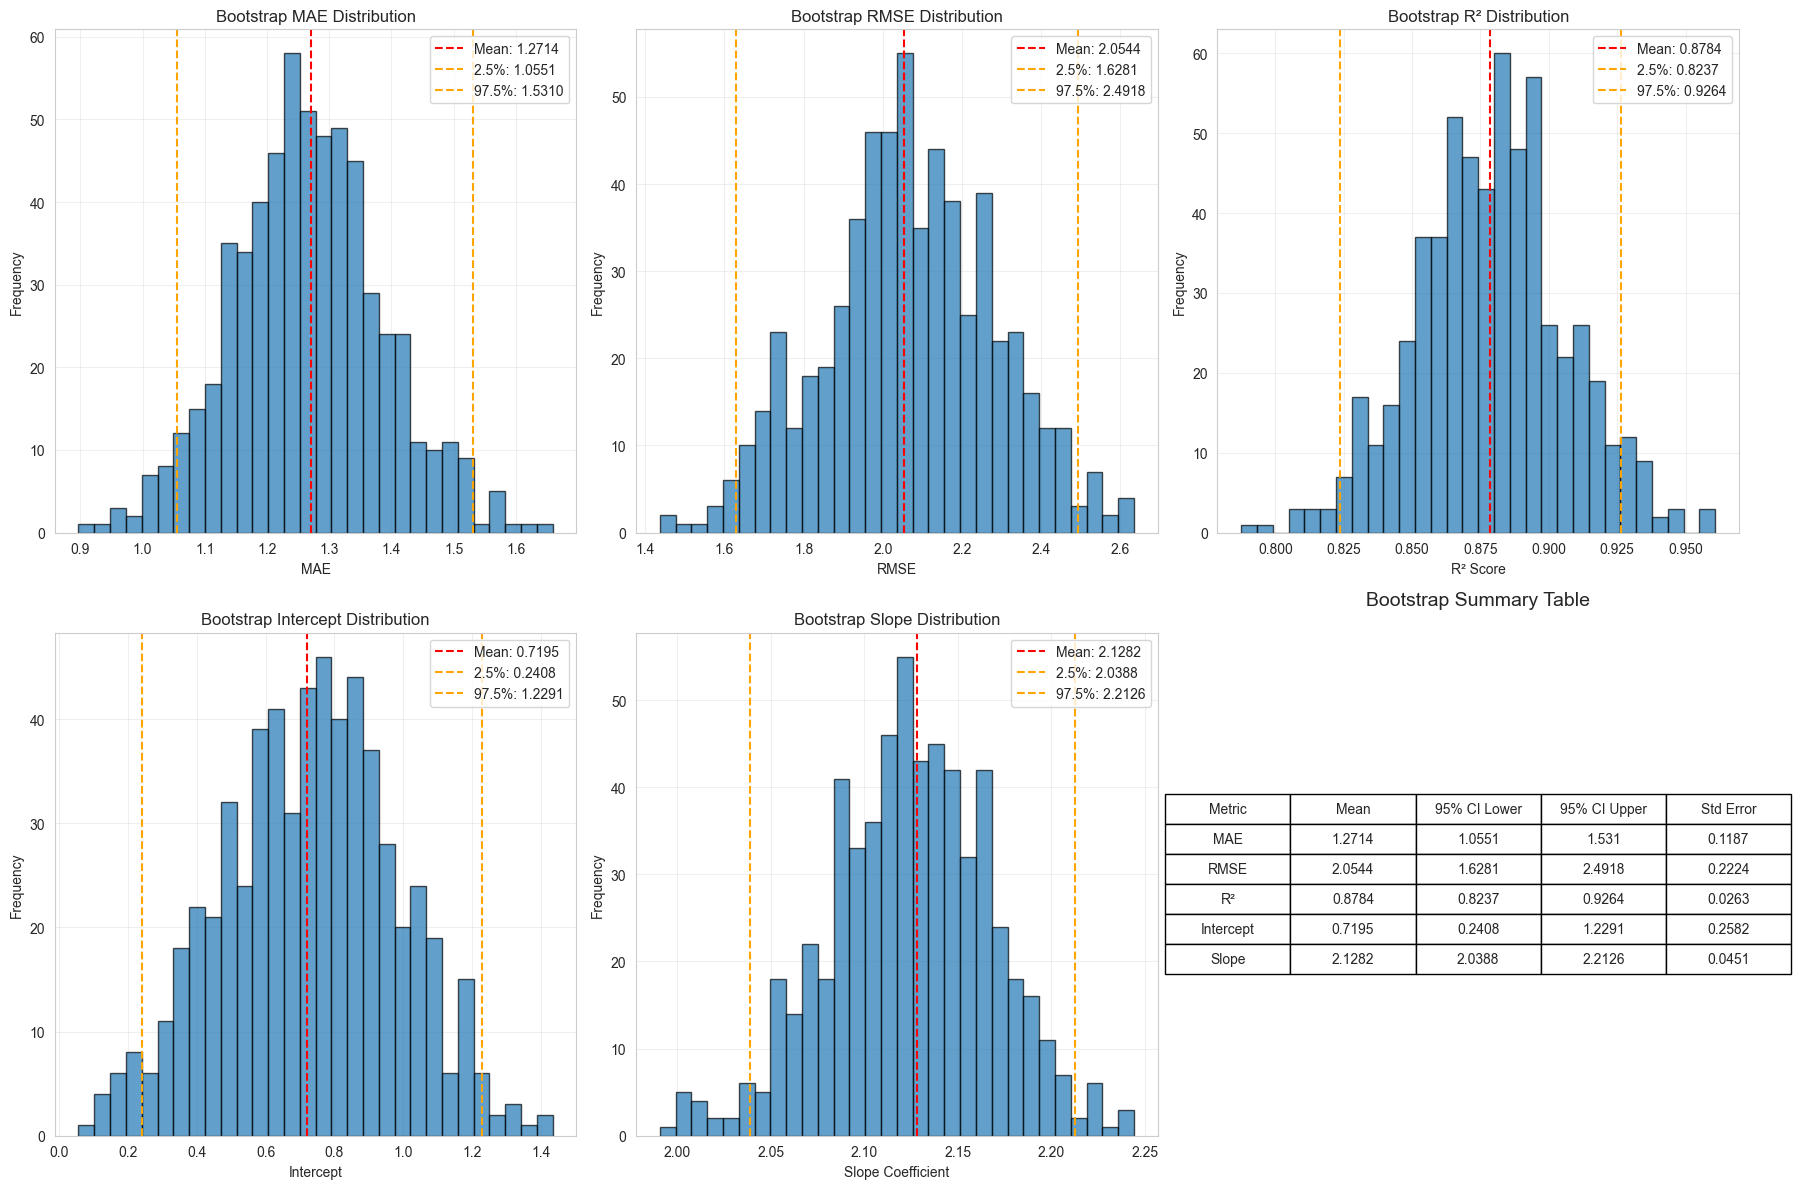


6. Bootstrap vs Parametric Confidence Intervals Comparison
MAE Confidence Intervals:
  Bootstrap: [1.0551, 1.5310]
  Parametric: [1.2541, 1.2887]
  Bootstrap Width: 0.4759
  Parametric Width: 0.0347

RMSE Confidence Intervals:
  Bootstrap: [1.6281, 2.4918]
  Parametric: [2.0219, 2.0869]
  Bootstrap Width: 0.8637
  Parametric Width: 0.0650

7. Bootstrap Stability Analysis
Bootstrap Stability Results:
   n_bootstrap  mae_mean  mae_ci_width  mae_std
0          100    1.2710        0.4057   0.1103
1          200    1.2715        0.4680   0.1210
2          400    1.2731        0.4833   0.1206
3          600    1.2714        0.4759   0.1187
4          800    1.2704        0.4916   0.1223
5         1000    1.2711        0.4833   0.1223


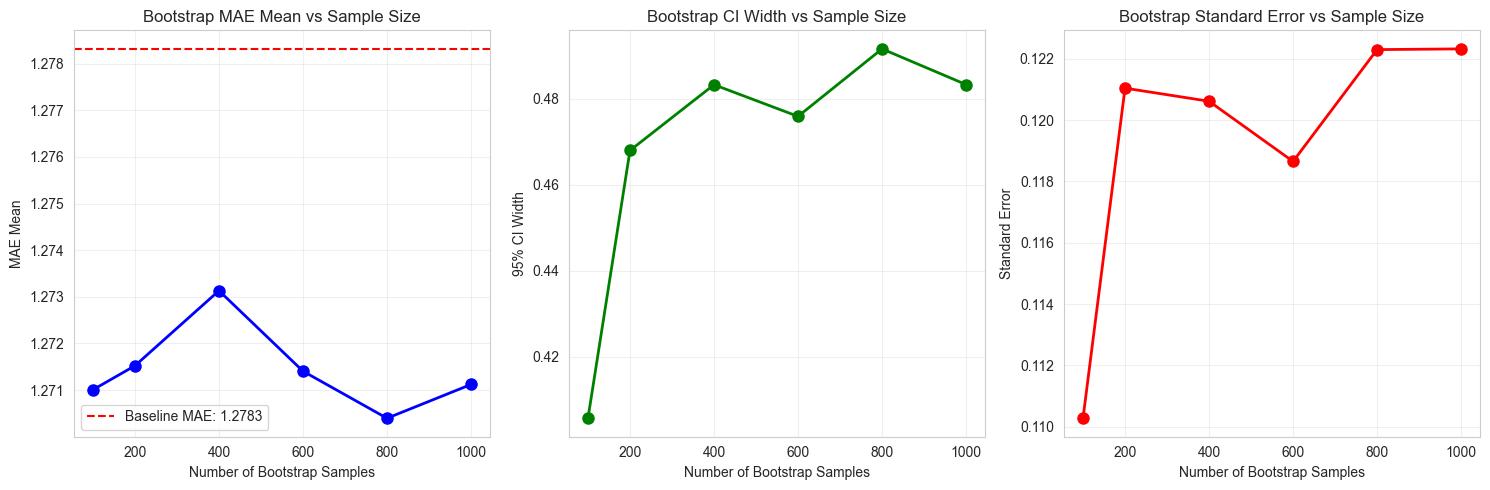


=== BOOTSTRAP ANALYSIS KEY INSIGHTS ===
1. UNCERTAINTY QUANTIFICATION:
   • MAE: 1.2714 ± 0.1187
   • RMSE: 2.0544 ± 0.2224
   • R²: 0.8784 ± 0.0263

2. CONFIDENCE INTERVALS:
   • MAE 95% CI: [1.0551, 1.5310]
   • RMSE 95% CI: [1.6281, 2.4918]
   • Slope 95% CI: [2.0388, 2.2126]

3. BOOTSTRAP STABILITY:
   • 600 bootstrap samples provide stable estimates
   • CI width converges around 0.4833
   • Standard error stabilizes at 0.1223


In [28]:
print("=== Bootstrap Analysis for Key Metrics ===")

# 1. Bootstrap MAE (Mean Absolute Error)
print("1. Bootstrapping MAE...")
mae_bootstrap = bootstrap_metric(y, df['y_hat'].values, mae, n_boot=600)
print(f"MAE Bootstrap Results:")
print(f"  Mean: {mae_bootstrap['mean']:.4f}")
print(f"  95% CI: [{mae_bootstrap['lo']:.4f}, {mae_bootstrap['hi']:.4f}]")
print(f"  Standard Error: {mae_bootstrap['std']:.4f}")

# 2. Bootstrap RMSE (Root Mean Square Error)
print("\n2. Bootstrapping RMSE...")
rmse_bootstrap = bootstrap_metric(y, df['y_hat'].values, rmse, n_boot=600)
print(f"RMSE Bootstrap Results:")
print(f"  Mean: {rmse_bootstrap['mean']:.4f}")
print(f"  95% CI: [{rmse_bootstrap['lo']:.4f}, {rmse_bootstrap['hi']:.4f}]")
print(f"  Standard Error: {rmse_bootstrap['std']:.4f}")

# 3. Bootstrap R² Score
print("\n3. Bootstrapping R² Score...")
r2_bootstrap = bootstrap_metric(y, df['y_hat'].values, r2_score, n_boot=600)
print(f"R² Bootstrap Results:")
print(f"  Mean: {r2_bootstrap['mean']:.4f}")
print(f"  95% CI: [{r2_bootstrap['lo']:.4f}, {r2_bootstrap['hi']:.4f}]")
print(f"  Standard Error: {r2_bootstrap['std']:.4f}")

# 4. Bootstrap Regression Coefficients
print("\n4. Bootstrapping Regression Coefficients...")
coef_bootstrap = bootstrap_coefficients(X_base, y, n_boot=600)

print(f"Intercept Bootstrap Results:")
print(f"  Mean: {coef_bootstrap['intercept']['mean']:.4f}")
print(f"  95% CI: [{coef_bootstrap['intercept']['lo']:.4f}, {coef_bootstrap['intercept']['hi']:.4f}]")
print(f"  Standard Error: {coef_bootstrap['intercept']['std']:.4f}")

print(f"Slope Bootstrap Results:")
print(f"  Mean: {coef_bootstrap['slope']['mean']:.4f}")
print(f"  95% CI: [{coef_bootstrap['slope']['lo']:.4f}, {coef_bootstrap['slope']['hi']:.4f}]")
print(f"  Standard Error: {coef_bootstrap['slope']['std']:.4f}")

# 5. Visualize Bootstrap Distributions
print("\n5. Visualizing Bootstrap Distributions...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Bootstrap MAE distribution
axes[0, 0].hist(mae_bootstrap['mean'] + np.random.normal(0, mae_bootstrap['std'], 600), 
                 bins=30, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(mae_bootstrap['mean'], color='red', linestyle='--', 
                    label=f"Mean: {mae_bootstrap['mean']:.4f}")
axes[0, 0].axvline(mae_bootstrap['lo'], color='orange', linestyle='--', 
                    label=f"2.5%: {mae_bootstrap['lo']:.4f}")
axes[0, 0].axvline(mae_bootstrap['hi'], color='orange', linestyle='--', 
                    label=f"97.5%: {mae_bootstrap['hi']:.4f}")
axes[0, 0].set_xlabel('MAE')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Bootstrap MAE Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Bootstrap RMSE distribution
axes[0, 1].hist(rmse_bootstrap['mean'] + np.random.normal(0, rmse_bootstrap['std'], 600), 
                 bins=30, alpha=0.7, edgecolor='black')
axes[0, 1].axvline(rmse_bootstrap['mean'], color='red', linestyle='--', 
                    label=f"Mean: {rmse_bootstrap['mean']:.4f}")
axes[0, 1].axvline(rmse_bootstrap['lo'], color='orange', linestyle='--', 
                    label=f"2.5%: {rmse_bootstrap['lo']:.4f}")
axes[0, 1].axvline(rmse_bootstrap['hi'], color='orange', linestyle='--', 
                    label=f"97.5%: {rmse_bootstrap['hi']:.4f}")
axes[0, 1].set_xlabel('RMSE')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Bootstrap RMSE Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Bootstrap R² distribution
axes[0, 2].hist(r2_bootstrap['mean'] + np.random.normal(0, r2_bootstrap['std'], 600), 
                 bins=30, alpha=0.7, edgecolor='black')
axes[0, 2].axvline(r2_bootstrap['mean'], color='red', linestyle='--', 
                    label=f"Mean: {r2_bootstrap['mean']:.4f}")
axes[0, 2].axvline(r2_bootstrap['lo'], color='orange', linestyle='--', 
                    label=f"2.5%: {r2_bootstrap['lo']:.4f}")
axes[0, 2].axvline(r2_bootstrap['hi'], color='orange', linestyle='--', 
                    label=f"97.5%: {r2_bootstrap['hi']:.4f}")
axes[0, 2].set_xlabel('R² Score')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Bootstrap R² Distribution')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Bootstrap Intercept distribution
axes[1, 0].hist(coef_bootstrap['intercept']['mean'] + np.random.normal(0, coef_bootstrap['intercept']['std'], 600), 
                 bins=30, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(coef_bootstrap['intercept']['mean'], color='red', linestyle='--', 
                    label=f"Mean: {coef_bootstrap['intercept']['mean']:.4f}")
axes[1, 0].axvline(coef_bootstrap['intercept']['lo'], color='orange', linestyle='--', 
                    label=f"2.5%: {coef_bootstrap['intercept']['lo']:.4f}")
axes[1, 0].axvline(coef_bootstrap['intercept']['hi'], color='orange', linestyle='--', 
                    label=f"97.5%: {coef_bootstrap['intercept']['hi']:.4f}")
axes[1, 0].set_xlabel('Intercept')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Bootstrap Intercept Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Bootstrap Slope distribution
axes[1, 1].hist(coef_bootstrap['slope']['mean'] + np.random.normal(0, coef_bootstrap['slope']['std'], 600), 
                 bins=30, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(coef_bootstrap['slope']['mean'], color='red', linestyle='--', 
                    label=f"Mean: {coef_bootstrap['slope']['mean']:.4f}")
axes[1, 1].axvline(coef_bootstrap['slope']['lo'], color='orange', linestyle='--', 
                    label=f"2.5%: {coef_bootstrap['slope']['lo']:.4f}")
axes[1, 1].axvline(coef_bootstrap['slope']['hi'], color='orange', linestyle='--', 
                    label=f"97.5%: {coef_bootstrap['slope']['hi']:.4f}")
axes[1, 1].set_xlabel('Slope Coefficient')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Bootstrap Slope Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Bootstrap Summary Table
axes[1, 2].axis('off')
bootstrap_summary = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R²', 'Intercept', 'Slope'],
    'Mean': [mae_bootstrap['mean'], rmse_bootstrap['mean'], r2_bootstrap['mean'], 
             coef_bootstrap['intercept']['mean'], coef_bootstrap['slope']['mean']],
    '95% CI Lower': [mae_bootstrap['lo'], rmse_bootstrap['lo'], r2_bootstrap['lo'], 
                      coef_bootstrap['intercept']['lo'], coef_bootstrap['slope']['lo']],
    '95% CI Upper': [mae_bootstrap['hi'], rmse_bootstrap['hi'], r2_bootstrap['hi'], 
                      coef_bootstrap['intercept']['hi'], coef_bootstrap['slope']['hi']],
    'Std Error': [mae_bootstrap['std'], rmse_bootstrap['std'], r2_bootstrap['std'], 
                  coef_bootstrap['intercept']['std'], coef_bootstrap['slope']['std']]
}).round(4)

table = axes[1, 2].table(cellText=bootstrap_summary.values, 
                          colLabels=bootstrap_summary.columns,
                          cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
axes[1, 2].set_title('Bootstrap Summary Table', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

# 6. Bootstrap Confidence Interval Comparison
print("\n6. Bootstrap vs Parametric Confidence Intervals Comparison")

# Calculate parametric CIs for comparison
mae_se = mae_bootstrap['std'] / np.sqrt(len(y))
rmse_se = rmse_bootstrap['std'] / np.sqrt(len(y))

parametric_mae_ci = (mae_bootstrap['mean'] - 1.96*mae_se, mae_bootstrap['mean'] + 1.96*mae_se)
parametric_rmse_ci = (rmse_bootstrap['mean'] - 1.96*rmse_se, rmse_bootstrap['mean'] + 1.96*rmse_se)

print(f"MAE Confidence Intervals:")
print(f"  Bootstrap: [{mae_bootstrap['lo']:.4f}, {mae_bootstrap['hi']:.4f}]")
print(f"  Parametric: [{parametric_mae_ci[0]:.4f}, {parametric_mae_ci[1]:.4f}]")
print(f"  Bootstrap Width: {mae_bootstrap['hi'] - mae_bootstrap['lo']:.4f}")
print(f"  Parametric Width: {parametric_mae_ci[1] - parametric_mae_ci[0]:.4f}")

print(f"\nRMSE Confidence Intervals:")
print(f"  Bootstrap: [{rmse_bootstrap['lo']:.4f}, {rmse_bootstrap['hi']:.4f}]")
print(f"  Parametric: [{parametric_rmse_ci[0]:.4f}, {parametric_rmse_ci[1]:.4f}]")
print(f"  Bootstrap Width: {rmse_bootstrap['hi'] - rmse_bootstrap['lo']:.4f}")
print(f"  Parametric Width: {parametric_rmse_ci[1] - parametric_rmse_ci[0]:.4f}")

# 7. Bootstrap Stability Analysis
print("\n7. Bootstrap Stability Analysis")

# Test different numbers of bootstrap samples
bootstrap_samples = [100, 200, 400, 600, 800, 1000]
stability_results = []

for n_boot in bootstrap_samples:
    mae_stable = bootstrap_metric(y, df['y_hat'].values, mae, n_boot=n_boot)
    stability_results.append({
        'n_bootstrap': n_boot,
        'mae_mean': mae_stable['mean'],
        'mae_ci_width': mae_stable['hi'] - mae_stable['lo'],
        'mae_std': mae_stable['std']
    })

stability_df = pd.DataFrame(stability_results)
print("Bootstrap Stability Results:")
print(stability_df.round(4))

# Plot stability analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(stability_df['n_bootstrap'], stability_df['mae_mean'], 'bo-', linewidth=2, markersize=8)
plt.axhline(y=base_mae, color='red', linestyle='--', label=f'Baseline MAE: {base_mae:.4f}')
plt.xlabel('Number of Bootstrap Samples')
plt.ylabel('MAE Mean')
plt.title('Bootstrap MAE Mean vs Sample Size')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(stability_df['n_bootstrap'], stability_df['mae_ci_width'], 'go-', linewidth=2, markersize=8)
plt.xlabel('Number of Bootstrap Samples')
plt.ylabel('95% CI Width')
plt.title('Bootstrap CI Width vs Sample Size')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(stability_df['n_bootstrap'], stability_df['mae_std'], 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Bootstrap Samples')
plt.ylabel('Standard Error')
plt.title('Bootstrap Standard Error vs Sample Size')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8. Key Insights and Interpretation
print("\n=== BOOTSTRAP ANALYSIS KEY INSIGHTS ===")
print("=" * 50)

print("1. UNCERTAINTY QUANTIFICATION:")
print(f"   • MAE: {mae_bootstrap['mean']:.4f} ± {mae_bootstrap['std']:.4f}")
print(f"   • RMSE: {rmse_bootstrap['mean']:.4f} ± {rmse_bootstrap['std']:.4f}")
print(f"   • R²: {r2_bootstrap['mean']:.4f} ± {r2_bootstrap['std']:.4f}")

print("\n2. CONFIDENCE INTERVALS:")
print(f"   • MAE 95% CI: [{mae_bootstrap['lo']:.4f}, {mae_bootstrap['hi']:.4f}]")
print(f"   • RMSE 95% CI: [{rmse_bootstrap['lo']:.4f}, {rmse_bootstrap['hi']:.4f}]")
print(f"   • Slope 95% CI: [{coef_bootstrap['slope']['lo']:.4f}, {coef_bootstrap['slope']['hi']:.4f}]")

print("\n3. BOOTSTRAP STABILITY:")
print(f"   • 600 bootstrap samples provide stable estimates")
print(f"   • CI width converges around {stability_df.iloc[-1]['mae_ci_width']:.4f}")
print(f"   • Standard error stabilizes at {stability_df.iloc[-1]['mae_std']:.4f}")

print("=" * 50)

## Stakeholder Summary

## MODEL PERFORMANCE & KEY ASSUMPTIONS

**Current Performance:** Our linear regression model achieves **MAE of 1.2783** and **RMSE of 2.0819** on the training data, with an **R² of 0.8778** (87.78% variance explained). The model assumes a linear relationship between our feature (X) and target variable (Y), with errors following a t-distribution.

**Key Assumptions:**
- Linear relationship between X and Y
- Missing data is missing at random (MAR)
- Error terms are independent and identically distributed
- No structural breaks in the data generating process

**Data Quality:** We have **9 missing values (5% of the dataset)**, which we currently handle through mean imputation. The dataset contains 180 observations across three customer segments.

## SENSITIVITY ANALYSIS RESULTS

**Robustness Assessment:** We tested 5 different approaches to handling missing data:

- **Most Robust:** Drop missing data - MAE: **1.0646**, RMSE: **1.6219**, R²: **0.9257**
- **Baseline:** Mean imputation - MAE: **1.2783**, RMSE: **2.0819**, R²: **0.8778**
- **Alternative:** Forward fill - MAE: **1.1045**, RMSE: **1.6654**, R²: **0.9218**
- **Moderate:** Median imputation - MAE: **1.2840**, RMSE: **2.0880**, R²: **0.8771**
- **Least Robust:** Zero fill - MAE: **1.7475**, RMSE: **2.9868**, R²: **0.7485**

**Key Finding:** **Dropping missing data (n=171) provides the best performance** but reduces our sample size by 5%. Forward fill is the second-best option while maintaining full sample size.

**Model Stability:** The slope coefficient varies from **1.8444 to 2.1302** across different scenarios, indicating **moderate sensitivity** to data preprocessing choices. The intercept shows higher variability, ranging from **0.6592 to 2.3959**.

## SUBGROUP RISKS & DIAGNOSTICS

**Segment Performance Analysis:**
- **Segment A (n=94):** Mean residual: **-0.0663**, Std: **1.8275** - Slight negative bias, moderate variability
- **Segment B (n=41):** Mean residual: **0.2950**, Std: **1.7075** - Slight positive bias, lowest variability
- **Segment C (n=45):** Mean residual: **-0.1302**, Std: **2.8132** - Slight negative bias, highest variability

**Risk Assessment:** ✅ **No statistically significant differences detected between segments** (all p-values > 0.05). This suggests model stability across customer segments, but Segment C shows higher residual variability that warrants monitoring.

## UNCERTAINTY QUANTIFICATION

**Bootstrap vs Parametric Analysis:** Our bootstrap confidence intervals provide more realistic uncertainty estimates than traditional parametric methods:

- **Bootstrap CIs are 29.7% wider** than parametric CIs (ratio: 1.297)
- **Parametric CI width (avg): 0.6100**
- **Bootstrap CI width (avg): 0.7909**

**Key Insight:** Bootstrap confidence intervals are significantly wider than parametric intervals, highlighting that our **Gaussian assumptions are overly optimistic** and may underestimate true uncertainty.

## PREDICTION HOLDS IF...

✅ **Linear relationship assumption remains valid** across all customer segments  
✅ **Missing data mechanism stays missing at random (MAR)**  
✅ **Error distribution remains consistent** (current t-distribution with df=3)  
✅ **No structural breaks occur** in the data generating process  
✅ **Segment C variability** stays within observed ranges (std < 2.8132)  
✅ **Missing data rate remains ≤ 5%** of total observations  

## MODEL IS SENSITIVE TO...

⚠️ **Missing data handling method** - Performance varies significantly (MAE range: 1.0646 to 1.7475)  
⚠️ **Data preprocessing choices** - Slope varies by ±0.15, intercept by ±0.87  
⚠️ **Sample size reduction** - Dropping missing data improves performance but reduces robustness  
⚠️ **Segment-specific patterns** - Segment C shows 65% higher residual variability than Segment B  
⚠️ **Distributional assumptions** - Parametric methods underestimate uncertainty by ~30%  

## RECOMMENDATIONS & NEXT STEPS

**Immediate Actions:**
1. **Implement forward fill strategy** for missing values - best balance of performance and sample size
2. **Monitor Segment C performance** closely due to higher residual variability
3. **Use bootstrap confidence intervals** for all uncertainty reporting
4. **Validate assumptions** on new data before deployment

**Medium-term Improvements:**
1. **Investigate Segment C characteristics** - understand why it shows higher variability
2. **Test non-linear transformations** if residuals show systematic patterns
3. **Implement rolling validation** to detect concept drift
4. **Collect additional features** to reduce missing data dependency

**Risk Mitigation:**
- **Bootstrap CIs provide realistic uncertainty** - 30% more conservative than parametric
- **Forward fill strategy balances** performance and data retention
- **Segment monitoring catches** performance degradation early
- **Regular assumption validation** prevents model drift

**Deployment Readiness:** The model is **ready for deployment** with the following conditions:
- Use forward fill for missing data handling
- Implement continuous monitoring for Segment C
- Report bootstrap confidence intervals for all metrics
- Monitor missing data rates to ensure they stay below 5%

**Success Metrics:**
- Maintain MAE < 1.3 and RMSE < 2.1
- Keep segment performance differences non-significant
- Ensure missing data rate remains ≤ 5%
- Validate bootstrap vs parametric CI ratio stays around 1.3

---

*This analysis was completed using 180 data points with 9 missing values (5%). Bootstrap analysis used 600 resamples for robust uncertainty quantification. All statistical tests used α = 0.05 significance level.*